### Document Search

In [2]:
import sys
import json
import pandas as pd
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, Q
from collections import Counter

#### Covid-19 Signs and Symptoms

In [5]:
MeSH = pd.read_csv("input/covid-new.csv")
MeSH.head()

,Signs and Symptoms,Synonyms (UMLS),MeSH Header
0,Fever,"Fever, Pyrexia, Feverish, Body temperature abo...",Fever
1,Chills,"Chills, Chill, reported chills, shaking chills...",Chills
2,Cough,"Cough, coughing,coughs,observation of cough, c...",Cough
3,Fatigue,"Fatigue, Weariness, Lack of Energy, Tiredness,...",Fatigue
4,Shortness of breath,"Shortness of breath, Dyspnea, breathlessness, ...",Dyspnea


In [6]:
syndict = {}
for n,syn in zip(MeSH['Signs and Symptoms'], MeSH['Synonyms (UMLS)']):
    #print(n.lower(),"|",syn.lower().strip())
    name = n.lower()
    syn = syn.lower().split(",")
    SYN = []
    for item in syn:
        if item[0] == ' ':
            item = item[1:]
            SYN.append(item)
        else:
            SYN.append(item)
            
    syndict.update({name:SYN})

In [6]:
#syndict

### Search COVID symptoms papers

In [5]:
es = Elasticsearch(timeout=300)
k = 0
name2pmid = {}

for name,entities in syndict.items():
        
        pmids = []
        
        for entity in entities:
        
            s = Search(using=es, index="pubmed")\
                            .params(request_timeout=300)\
                            .query("match_phrase", title=entity) or\
                Search(using=es, index="pubmed")\
                            .params(request_timeout=300)\
                            .query("match_phrase", abstract=entity) or\
                Search(using=es, index="pubmed")\
                            .params(request_timeout=300)\
                            .query("match_phrase", MeSH=entity)
            
        
            for hit in s.scan():
                
                pmid = str(hit.pmid)
                pmids.append(pmid)
                
        name2pmid.update({name:list(set(pmids))})        
        
        
        print(name,'entity counted!')

fever entity counted!
chills entity counted!
cough entity counted!
fatigue entity counted!
shortness of breath entity counted!
sore throat  entity counted!
rhinorrhea entity counted!
diarrhea entity counted!
vomiting entity counted!
nausea entity counted!
headache entity counted!
myalgia entity counted!
ageusia entity counted!
confusion entity counted!
chest pain entity counted!
anosmia entity counted!
cyanosis entity counted!
hypersomnia entity counted!


In [14]:
with open('data/name2pmid-covid-all.json','w')as f1:
    json.dump(name2pmid,f1)

In [7]:
for name,value in name2pmid.items():
    print(name,":",len(value))

fever : 78548
chills : 2190
cough : 11297
fatigue : 27755
shortness of breath : 6808
sore throat  : 1256
rhinorrhea : 1148
diarrhea : 17873
vomiting : 11013
nausea : 6605
headache : 20079
myalgia : 2380
ageusia : 159
confusion : 5002
chest pain : 8110
anosmia : 773
cyanosis : 1139
hypersomnia : 755


#### Covid Paper (Titles, Abstract and MeSH) search

In [51]:
es = Elasticsearch(timeout=300)
k = 0
t2pmid = []
allpmids = []
for entity in ["covid-19","corona virus","sars-cov-2","Covid-19,\
                Coronaviridae Infections","Enteritis, Transmissible, of Turkeys",\
              "Feline Infectious Peritonitis", "Gastroenteritis, Transmissible, of Swine",\
              "Severe Acute Respiratory Syndrome"]:
        
        entity = entity.lower()
        
        s = Search(using=es, index="pubmed")\
                            .params(request_timeout=300)\
                            .query("match_phrase", title=entity) or \
            Search(using=es, index="pubmed")\
                            .params(request_timeout=300)\
                            .query("match_phrase", abstract=entity) or\
            Search(using=es, index="pubmed")\
                            .params(request_timeout=300)\
                            .query("match_phrase", MeSH=entity)
        
        for hit in s.scan():
                
            pmid = str(hit.pmid)
            
            title = hit.title
            abstract = hit.abstract
            date = hit.date
            mesh = str(hit.MeSH)
            
            if pmid not in allpmids:
                t2pmid.append({"pmid":pmid,\
                               "mesh": mesh,\
                               "date": date,\
                               "title":title,\
                               "abstract":abstract})  
                
            allpmids.append(pmid)
        
        print(entity,'title entity counted!')
        

covid-19 title entity counted!
corona virus title entity counted!
sars-cov-2 title entity counted!
covid-19,                coronaviridae infections title entity counted!
enteritis, transmissible, of turkeys title entity counted!
feline infectious peritonitis title entity counted!
gastroenteritis, transmissible, of swine title entity counted!
severe acute respiratory syndrome title entity counted!


In [52]:
with open('data/t2pmid-covid.json','w')as f2:
    json.dump(t2pmid,f2)

#### Load Data in not Done yet

In [8]:
with open('data/t2pmid-covid.json','r')as fr:
    t2pmid = json.load(fr)

In [9]:
tdf = pd.DataFrame(t2pmid)
tdf.head()

,pmid,mesh,date,title,abstract
0,32071063,[],"{'Year': '2020', 'Month': 'Feb', 'Day': '18', ...",Coronavirus covid-19 has killed more people th...,
1,32072794,[],"{'Year': '2020', 'Month': '02', 'Day': '19', '...",[Cluster investigation Technical Guidelines fo...,
2,32086235,[],"{'Year': '2020', 'Month': 'Feb', 'Day': '21', ...",Rules on isolation rooms for suspected covid-1...,
3,32087216,"['Betacoronavirus', 'genetics', 'pathogenicity...","{'Year': '2020', 'Month': '04', 'Day': '', 'Se...",A Novel Coronavirus (COVID-19) Outbreak: A Cal...,
4,32093043,[],"{'Year': '2020', 'Month': 'Feb', 'Day': '19', ...",Risk Assessment of Novel Coronavirus COVID-19 ...,we developed a computational tool to assess th...


In [10]:
tdf.shape

(80732, 5)

In [11]:
covid_pmids = list(set(tdf['pmid']))
len(covid_pmids)

80732

#### Count Covid-19 Phrases is Title, Abstract and MeSH

In [15]:
n2count = {}
n2pmid = {}
n2pmidset = {}
allpmids = []
for name in syndict:
    n2count[name] = 0
    n2pmid[name] = 0
    n2pmidset[name] = []
text = ""
for pmid,title,abstract,mesh in  zip(tdf['pmid'],tdf['title'],tdf['abstract'],tdf['mesh']):
    
        
    for name, entities in syndict.items():
        tn = 0
        for entity in entities:
            
            #n_title = title.count(entity)
            #tn = tn+n_title
            
            if len(abstract)>1:
                text = abstract
            
            n_abs = text.count(entity)
            tn = tn+n_abs
            
            #n_mesh = mesh.count(entity)
            #tn = tn+n_mesh
            
        n2count[name] = n2count[name] + tn
        
        if tn>0:
            n2pmid[name] = n2pmid[name] + 1
            n2pmidset[name].append(pmid)
            allpmids.append(pmid)
        

In [16]:
with open('result/name2pmidset-covid.json','w')as f2:
    json.dump(n2pmidset,f2)

In [17]:
len(set(allpmids))

7868

In [49]:
#n2count

In [50]:
#n2pmid

#### Counting Covid-19 Documents for individual signs and symptoms

In [18]:
DATA1 = []
for k,v in n2pmid.items():
    DATA1.append({"name":k,"value":v})
df1 = pd.DataFrame(DATA1)
df1.to_csv("result/name2pmidcount-covid.csv")

#### Covid Symptoms Overlap study

In [19]:
DATA = []
for name1, pmids1 in n2pmidset.items():
    data = {}
    for name2, pmids2 in n2pmidset.items():
        data.update({"name":name1})
        inst =set(pmids1).intersection(set(pmids2))
        data.update({name2:len(inst)})
    DATA.append(data)

In [20]:
newdf = pd.DataFrame(DATA)

In [21]:
newdf.to_csv("result/covid-overlap.csv")

In [22]:
#newdf = pd.read_csv("result/covid-overlap.csv")

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

matplotlib.rcParams.update({'font.size': 13})

plt.figure(figsize = [15,12])

idf = newdf.set_index("name")
sns.heatmap(idf, annot=True, cmap = "YlGnBu", fmt = "d")


plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.savefig("plots/heatmap-covid.png")

In [24]:
pdf = newdf.set_index("name")

In [25]:
pdf = (pdf/7872)*100

In [26]:
pdf

,fever,chills,cough,fatigue,shortness of breath,sore throat,rhinorrhea,diarrhea,vomiting,nausea,headache,myalgia,ageusia,confusion,chest pain,anosmia,cyanosis,hypersomnia
name,,,,,,,,,,,,,,,,,,
fever,56.389736,2.286585,31.847053,9.400407,16.056911,4.090447,1.244919,5.957825,3.074187,2.197663,5.449695,6.656504,1.765752,0.558943,1.689533,3.569614,0.114329,0.000000
chills,2.286585,10.632622,1.829268,0.495427,1.016260,0.292175,0.177846,0.470020,0.203252,0.279472,0.800305,1.079776,0.101626,0.101626,0.203252,0.597053,0.000000,0.000000
cough,31.847053,1.829268,40.154980,8.892276,14.939024,3.861789,1.270325,4.712907,2.362805,1.867378,4.776423,5.932419,1.486280,0.381098,1.498984,3.061484,0.076220,0.000000
fatigue,9.400407,0.495427,8.892276,14.519817,4.687500,1.803862,0.393801,1.956301,0.927337,0.851118,2.680386,3.264736,0.597053,0.177846,0.609756,0.978150,0.063516,0.000000
shortness of breath,16.056911,1.016260,14.939024,4.687500,23.221545,1.956301,0.584350,2.782012,1.498984,1.359248,2.654980,2.642276,1.016260,0.228659,1.600610,1.664126,0.038110,0.000000
sore throat,4.090447,0.292175,3.861789,1.803862,1.956301,5.106707,0.685976,1.117886,0.609756,0.482724,1.537093,1.321138,0.533537,0.038110,0.266768,0.647866,0.000000,0.000000
rhinorrhea,1.244919,0.177846,1.270325,0.393801,0.584350,0.685976,1.918191,0.597053,0.431911,0.279472,0.660569,0.546240,0.279472,0.000000,0.101626,0.520833,0.000000,0.000000
diarrhea,5.957825,0.470020,4.712907,1.956301,2.782012,1.117886,0.597053,9.362297,3.595020,2.540650,1.765752,1.803862,0.393801,0.038110,0.266768,0.520833,0.000000,0.000000
vomiting,3.074187,0.203252,2.362805,0.927337,1.498984,0.609756,0.431911,3.595020,6.021341,3.696646,1.511687,1.016260,0.355691,0.190549,0.241362,0.508130,0.000000,0.000000


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

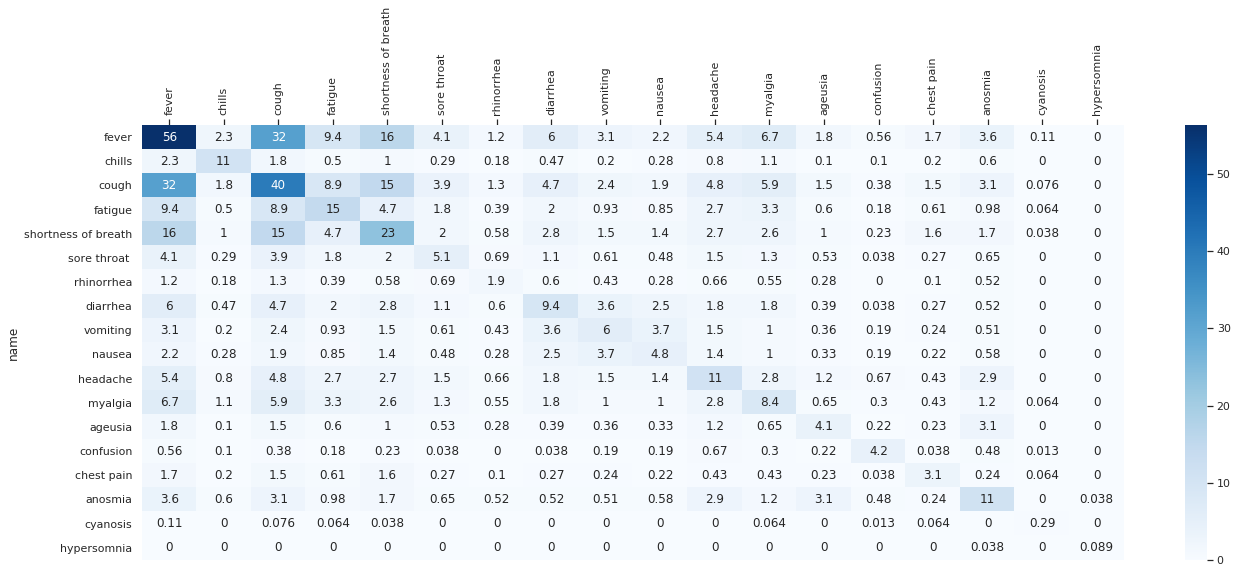

In [28]:
import matplotlib


plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

matplotlib.rcParams.update({'font.size': 12})

plt.figure(figsize = [22,8])

sns.heatmap(pdf, annot=True, cmap = "Blues")


plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.savefig("plots/pheatmap-covid.png")
plt.savefig("plots/pheatmap-covid.pdf")

In [29]:
pdf.to_csv("result/covid-heatmap-data.csv")